In [ ]:
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
#src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
src_path = os.path.join(project_root, 'QUANT-PYTHON-LAST-ASSING', 'src')
sys.path.append(project_root)
sys.path.append(src_path)

'../data/'

Rebalancing date: 2016-01-01


2025-06-17 14:08:34,336 INFO: Fundamentals 2015-12-31 → 2016-01-01 | k=50


Rebalancing date: 2016-04-28


2025-06-17 14:08:42,256 INFO: Fundamentals 2016-03-31 → 2016-04-28 | k=50


Rebalancing date: 2016-08-24


2025-06-17 14:08:47,749 INFO: Fundamentals 2016-07-31 → 2016-08-24 | k=50


Rebalancing date: 2016-12-20


2025-06-17 14:08:55,373 INFO: Fundamentals 2016-11-30 → 2016-12-20 | k=50


Rebalancing date: 2017-04-17


2025-06-17 14:09:03,646 INFO: Fundamentals 2017-03-31 → 2017-04-17 | k=50


Rebalancing date: 2017-08-11


2025-06-17 14:09:10,667 INFO: Fundamentals 2017-07-31 → 2017-08-11 | k=50


Rebalancing date: 2017-12-07


2025-06-17 14:09:17,418 INFO: Fundamentals 2017-11-30 → 2017-12-07 | k=50


Rebalancing date: 2018-04-04


2025-06-17 14:09:26,517 INFO: Fundamentals 2018-03-31 → 2018-04-04 | k=50


Rebalancing date: 2018-07-31


2025-06-17 14:09:39,734 INFO: Fundamentals 2018-07-31 → 2018-07-31 | k=50


Rebalancing date: 2018-11-26


2025-06-17 14:09:51,382 INFO: Fundamentals 2018-10-31 → 2018-11-26 | k=50


Rebalancing date: 2019-03-22


2025-06-17 14:10:01,966 INFO: Fundamentals 2019-02-28 → 2019-03-22 | k=50


Rebalancing date: 2019-07-18


2025-06-17 14:10:10,943 INFO: Fundamentals 2019-06-30 → 2019-07-18 | k=50


Rebalancing date: 2019-11-13


2025-06-17 14:10:19,794 INFO: Fundamentals 2019-10-31 → 2019-11-13 | k=50


Rebalancing date: 2020-03-10


2025-06-17 14:10:28,032 INFO: Fundamentals 2020-02-29 → 2020-03-10 | k=50


Rebalancing date: 2020-07-06


2025-06-17 14:10:40,402 INFO: Fundamentals 2020-06-30 → 2020-07-06 | k=50


Rebalancing date: 2020-10-30


2025-06-17 14:10:49,583 INFO: Fundamentals 2020-09-30 → 2020-10-30 | k=50


Rebalancing date: 2021-02-25


2025-06-17 14:10:57,489 INFO: Fundamentals 2021-01-31 → 2021-02-25 | k=50


Rebalancing date: 2021-06-23


2025-06-17 14:11:11,423 INFO: Fundamentals 2021-05-31 → 2021-06-23 | k=50


Rebalancing date: 2021-10-19


2025-06-17 14:11:28,994 INFO: Fundamentals 2021-09-30 → 2021-10-19 | k=50


Rebalancing date: 2022-02-14


2025-06-17 14:11:43,046 INFO: Fundamentals 2022-01-31 → 2022-02-14 | k=50


Rebalancing date: 2022-06-10


2025-06-17 14:11:55,181 INFO: Fundamentals 2022-05-31 → 2022-06-10 | k=50


Rebalancing date: 2022-10-06


2025-06-17 14:12:05,031 INFO: Fundamentals 2022-09-30 → 2022-10-06 | k=50


Rebalancing date: 2023-02-01


2025-06-17 14:12:16,500 INFO: Fundamentals 2023-01-31 → 2023-02-01 | k=50


Rebalancing date: 2023-05-30


2025-06-17 14:12:25,704 INFO: Fundamentals 2023-04-30 → 2023-05-30 | k=50


Rebalancing date: 2023-09-25


2025-06-17 14:12:37,699 INFO: Fundamentals 2023-08-31 → 2023-09-25 | k=50


Rebalancing date: 2024-01-19


2025-06-17 14:12:51,850 INFO: Fundamentals 2023-12-31 → 2024-01-19 | k=50



Performance metrics

      AnnRet  AnnVol  Sharpe   MaxDD
LSTM  0.0999  0.1574  0.6349 -0.3207
SPI   0.0682  0.1387  0.4919 -0.2633


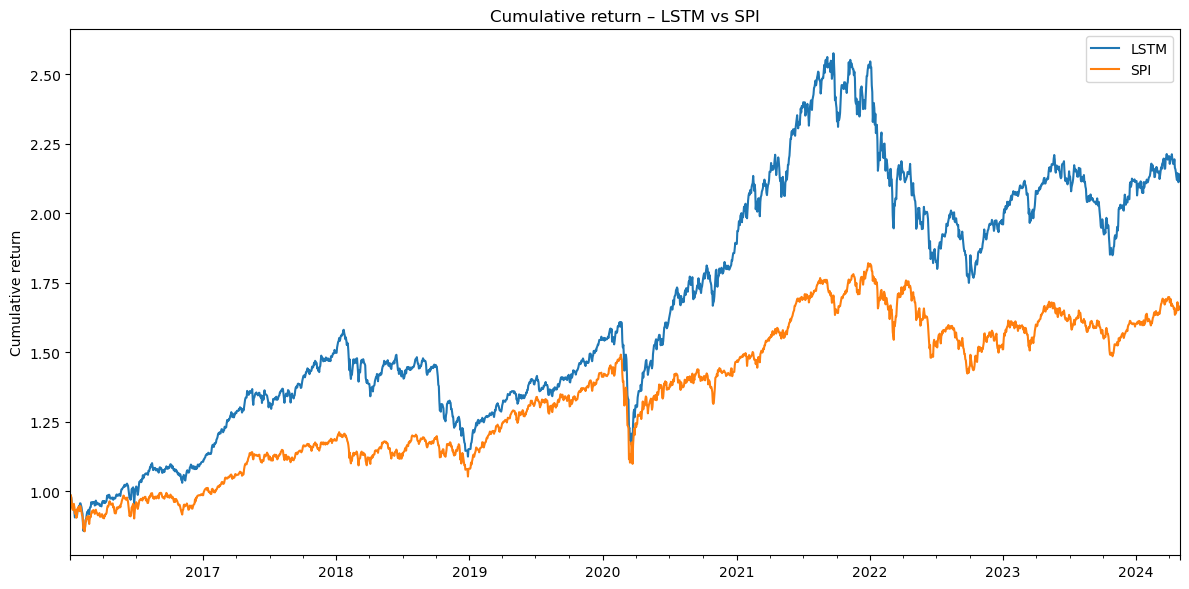

In [8]:
# LSTM Mean–Variance Portfolio  ·  50 JKP factors 

#  deterministic μ (no MC-Dropout)
#  α-boost 1.8  +  turnover shrink 1.00 / 0.95
#  fixed λ = 1.5   (no dynamic rescale)

import os, sys, random, logging, warnings, types, itertools
from typing import Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#justus mac:




from helper_functions import load_data_spi
from estimation.covariance import Covariance
from optimization.optimization import MeanVariance, Objective
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest
from backtesting.backtest_item_builder_classes import SelectionItemBuilder, OptimizationItemBuilder
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume, bibfn_selection_gaps, bibfn_return_series,
    bibfn_budget_constraint, bibfn_box_constraints)
from qpsolvers import available_solvers

#  reproducibility and logging 
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO,
                    
                    format="%(asctime)s %(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

sys.modules["xgboost"] = types.ModuleType("xgboost")   # qpsolvers workaround

# paths/dates

DATA_PATH  = '../data/'
START_DATE = "2016-01-01"
REB_PERIOD = 84 # quarterly
TRADING_DAYS = 252

# model and optimiser knobs
INIT_LAMBDA = 1.5
ALPHA_BOOST   = 1.80
GAMMA         = 0.002

HIDDEN, DROPOUT = 128, 0.30 #hidden state vector length, dropout rate? 
MAX_EPOCHS, PATIENCE = 100, 10 
LR, WD  = 1e-3, 1e-4 #Learnign rate, WD is? 
SEQ_LEN = 30   # look-back 30 days
FCAST_HORIZON = 1

TURN_SHRINK_LOW, TURN_SHRINK_HIGH = 1.00, 0.95
DISP_TH = 0.05

FIXED_ANNUAL, VC = 0.01, 0.002
FC = FIXED_ANNUAL * (REB_PERIOD / TRADING_DAYS)


#  50 JKP factors 
FUND_COLS = [
    
    "be_me", "op_at", "inv_gr1a", "ret_12_1", "beta_60m",
    
    "gp_at", "at_me", "rd_sale", "turnover_126d", "ivol_capm_252d", "f_score",
    
    "niq_be", "cash_at", "sale_gr1", "sale_gr3", "sale_me", "ocf_me",
    "netdebt_me", "gp_atl1", "op_atl1", "oaccruals_at", "taccruals_at",
    "capx_gr1", "capx_gr2", "capx_gr3", "inv_gr1", "rd_me", "rd5_at",
    "age", "tangibility", "kz_index", "ivol_ff3_21d", "ivol_hxz4_21d",
    "rvol_21d", "betadown_252d", "bidaskhl_21d", "rmax1_21d",
    "iskew_capm_21d", "coskew_21d", "turnover_var_126d", "dolvol_126d",
    "ami_126d", "zero_trades_252d", "corr_1260d", "rmax5_21d", "ret_6_1",
    "ret_9_1", "ret_12_7", "mispricing_mgmt", "qmj_growth"
]  

technical_features: pd.DataFrame = pd.DataFrame()

# helper to build tech panel 
def create_tech(ret: pd.DataFrame, vol: pd.DataFrame) -> pd.DataFrame:

    f, cum = pd.DataFrame(index=ret.index), (1+ret.fillna(0)).cumprod()
    for m in [1,3,6,12]:
        d=m*21; f[f"mom_{m}m"]=(cum/cum.shift(d)-1).mean(axis=1)

    for m in [1,3,6]:
        d=m*21; f[f"vol_{m}m"]=(ret.rolling(d,int(.7*d)).std().mean(axis=1)*np.sqrt(252))

    f["vol_trend"] = (vol.rolling(21,15).mean()/vol.rolling(63,45).mean()-1).mean(axis=1)
    f["breadth"]    = (ret>0).mean(axis=1)
    f["dispersion"] = ret.std(axis=1)

    return f.fillna(0)

class LSTMReturnPredictor(nn.Module):

    def __init__(self, inp:int, n:int):
        super().__init__()
        self.lstm=nn.LSTM(inp,HIDDEN,2,dropout=DROPOUT,batch_first=True)
        self.dp=nn.Dropout(DROPOUT); self.fc=nn.Linear(HIDDEN,n)

    def forward(self,x):
        out,_=self.lstm(x)
        return torch.tanh(self.fc(self.dp(out[:,-1,:])))*0.02

def pick_solver(pref="osqp"):
    solvers=available_solvers() if callable(available_solvers) else available_solvers
    return pref if pref in solvers else (solvers[0] if solvers else pref)

# optimisation class
class LSTMOptimization(MeanVariance):

    def __init__(self, **kw):
        super().__init__(solver_name=pick_solver(), **kw)
        self.net:Optional[LSTMReturnPredictor]=None
        self.input_dim:Optional[int]=None
        self.data:Optional[BacktestData]=None

    def _train(self,net,x,y):
        dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net.to(dev); x,y=x.to(dev),y.to(dev)
        opt=torch.optim.AdamW(net.parameters(),lr=LR,weight_decay=WD)
        crit=nn.MSELoss(); best=np.inf; pat=0

        for epoch in range(MAX_EPOCHS):
            opt.zero_grad(); loss=crit(net(x),y); loss.backward(); opt.step()

            if loss.item()+1e-8<best: best,pat=loss.item(),0
            else:
                pat+=1
                if pat>=PATIENCE: break
        net.cpu()

    def _flat_funda(self,date,ids):
        jkp=self.data.jkp_data

        if jkp is None: return None
        dates=jkp.index.get_level_values(0).unique()
        idx=dates.searchsorted(date,side="right")-1

        if idx<0: return None
        eff=dates[idx]
        try: mat=jkp[FUND_COLS].xs(eff,level=0).loc[ids].fillna(0)
        except KeyError: return None
        mat=(mat-mat.mean())/mat.std().replace(0,1)
        logger.info("Fundamentals %s → %s | k=%d",eff.date(),date.date(),len(mat.columns))

        return mat.to_numpy().ravel()
    
    def set_objective(self,optimization_data):

        X=optimization_data["return_series"]; ids=X.columns.tolist()
        cov=self.covariance.estimate(X=X,inplace=False).fillna(0)
        tech=technical_features.reindex(X.index).fillna(0)
        reb=X.index[-1]; funda=self._flat_funda(reb,ids)

        seqs,tgt=[],[]

        for i in range(SEQ_LEN,len(X)-FCAST_HORIZON):
            blk=np.hstack([X.values[i-SEQ_LEN:i],tech.values[i-SEQ_LEN:i]])
            if funda is not None:
                blk=np.hstack([blk,np.repeat(funda[np.newaxis,:],SEQ_LEN,0)])
            seqs.append(blk); tgt.append(X.values[i+FCAST_HORIZON])
        mu=pd.Series(0.,index=ids)

        if len(seqs)>=50:
            x_t=torch.tensor(np.stack(seqs),dtype=torch.float32)
            y_t=torch.tensor(np.stack(tgt ),dtype=torch.float32)
            d=x_t.shape[-1]
            if (self.net is None) or (d!=self.input_dim):
                self.input_dim=d; self.net=LSTMReturnPredictor(d,len(ids))
            self._train(self.net,x_t,y_t)
            with torch.no_grad():
                mu_hat=self.net(torch.tensor(seqs[-1:],dtype=torch.float32)).cpu().numpy().flatten()
            mu=pd.Series(mu_hat,index=ids).clip(-0.05,0.05)

        sig=pd.Series(np.sqrt(np.diag(cov)),index=ids)
        mu=(mu/sig.pow(0.5)*ALPHA_BOOST).fillna(0)
        disp=technical_features.loc[reb,"dispersion"]
        mu*=TURN_SHRINK_LOW if disp<DISP_TH else TURN_SHRINK_HIGH

        lam=INIT_LAMBDA  
        P=cov.values*2*lam + np.eye(len(ids))*2*GAMMA
        self.objective=Objective(q=-mu,
                                 P=pd.DataFrame(P,index=ids,columns=ids))

# performance helper
def perf(ret,bench):
    df=pd.concat([ret.rename("LSTM"),bench.rename("SPI")],axis=1).dropna()
    cum=(1+df).cumprod(); out={}
    for c in df:
        r=df[c]; ar, av=r.mean()*252, r.std()*np.sqrt(252)
        dd=(cum[c]-cum[c].cummax())/cum[c].cummax()
        out[c]=[ar,av,ar/av if av>0 else np.nan,dd.min()]
    return pd.DataFrame(out,index=["AnnRet","AnnVol","Sharpe","MaxDD"]).T,cum

# back-test runner 
def run_backtest(plot=True):
    #portolio wights limirts
    upper = 0.05 #
    lower = 0.0 
    global technical_features
    data=BacktestData()
    data.market_data=pd.read_parquet(os.path.join(DATA_PATH,"market_data.parquet"))
    try: data.jkp_data=pd.read_parquet(os.path.join(DATA_PATH,"jkp_data.parquet"))
    except FileNotFoundError: data.jkp_data=None
    data.bm_series=load_data_spi(path=DATA_PATH)
    technical_features=create_tech(data.get_return_series(),
                                   data.get_volume_series())

    dates=data.market_data.index.get_level_values("date").unique().sort_values()
    rdates=dates[dates>=pd.to_datetime(START_DATE)][::REB_PERIOD]

    sel={"vol":SelectionItemBuilder(bibfn=bibfn_selection_min_volume,width=252,
                                    min_volume=500_000,agg_fn=np.median),
         "gaps":SelectionItemBuilder(bibfn=bibfn_selection_gaps,width=252,n_days=7)}
    opt={"ret":OptimizationItemBuilder(bibfn=bibfn_return_series,width=252,fill_value=0),
         "budget":OptimizationItemBuilder(bibfn=bibfn_budget_constraint,budget=1.0),
         "box":OptimizationItemBuilder(bibfn=bibfn_box_constraints,lower=lower,upper=upper)}

    optimization=LSTMOptimization()
    optimization.data=data
    bs=BacktestService(data=data,
                       selection_item_builders=sel,
                       optimization_item_builders=opt,
                       optimization=optimization,
                       rebdates=[d.strftime("%Y-%m-%d") for d in rdates])
    bt=Backtest(); bt.run(bs)

    sim=bt.strategy.simulate(return_series=data.get_return_series(),fc=FC,vc=VC)
    metrics,cum=perf(sim,data.bm_series)
    if plot:
        print("\nPerformance metrics\n"); print(metrics.round(4))
        cum.plot(figsize=(12,6),title="Cumulative return – LSTM vs SPI")
        plt.ylabel("Cumulative return"); plt.tight_layout(); plt.show()
    return metrics,cum

# CLI 
if __name__=="__main__":
    run_backtest(plot=True)
